In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rc

import warnings
warnings.filterwarnings(action='ignore')

mpl.rcParams['axes.unicode_minus'] = False
font_path = 'C:/jupyter_home/font/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

2020년 1월~12월
기상데이터, 대기질 데이터 이용
기상데이터를 통한 PM10(미세먼지) 단계 예측

# 0. Data Load
### 0-1. 대기질데이터

In [74]:
# 월별 대기질 데이터 로드
month_air_quality = []
for i in range(12) :
    month_air_quality.append(pd.read_excel('C:/jupyter_home/data/finedust/'+str(i+1)+'월.xls'))
    month_air_quality[i] = month_air_quality[i].drop([month_air_quality[i].index[0]])

# 하나의 데이터 프레임으로 합침
air_quality = month_air_quality[0]
for i in range(1, 12):
    air_quality = pd.concat([air_quality, month_air_quality[i]], axis=0)

In [119]:
air_quality.head()

,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스,일
날짜,,,,,,,
2020-01-01 01:00:00,24,19,0.002,0.036,0.5,0.003,2020-01-01
2020-01-01 02:00:00,25,21,0.001,0.039,0.6,0.003,2020-01-01
2020-01-01 03:00:00,29,23,0.001,0.037,0.9,0.003,2020-01-01
2020-01-01 04:00:00,26,22,0.001,0.036,0.6,0.002,2020-01-01
2020-01-01 05:00:00,25,19,0.001,0.035,0.6,0.002,2020-01-01


### 0-2. 기상데이터
- columns
'일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)',
'증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)',
'일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )'

In [76]:
weather = pd.read_csv('C:/jupyter_home/data/finedust/20년 기상.csv')
weather.drop(['지점', '지점명'], axis=1, inplace=True)

In [77]:
weather.head()

,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),최저운고(100m )
0,2020-01-01 01:00,-5.9,NaN,1.7,50,40,1.6,-17.3,1021.8,1033.0,NaN,NaN,9.0,9.0,7.0
1,2020-01-01 02:00,-5.7,NaN,0.1,0,42,1.7,-16.5,1021.6,1032.8,NaN,NaN,9.0,9.0,7.0
2,2020-01-01 03:00,-5.6,0.0,0.0,0,46,1.8,-15.4,1021.5,1032.7,NaN,NaN,9.0,9.0,14.0
3,2020-01-01 04:00,-5.4,NaN,0.0,0,50,2.0,-14.2,1021.6,1032.8,NaN,NaN,8.0,8.0,6.0
4,2020-01-01 05:00,-5.2,NaN,0.0,0,55,2.3,-12.8,1021.1,1032.3,NaN,NaN,9.0,9.0,5.0


# 1. Data Preprocessing
- 날짜 형식 맞추기
- 결치값 처리
- 데이터 타입 변환

In [78]:
from datetime import datetime, date
from datetime import timedelta

### 대기질

1. yyyy-mm-dd hh:mm 형식으로 나타내기
2. 연도 추가
3. yyyy-mm-dd hh:mm -> hh가 24시인것 dd+1 해주어야함

In [79]:
# 날짜 형식 맞추기
air_quality['날짜'] = air_quality['날짜'].map(lambda x : '2020-'+x[:5]+" "+x[6:]+":00" )

def converting_date(x):
    h = x[11:13]
    d = x[:10]
    if h == '24' :
        d = datetime.strptime(d, '%Y-%m-%d')  # 문자열 => datetime
        d = d + timedelta(days=1)
        d = datetime.strftime(d, '%Y-%m-%d %H:%M') # datetime => 문자열
        return d
    else :
        return x

air_quality['날짜'] = air_quality['날짜'].map(converting_date)

In [80]:
# 결치값 처리
print(air_quality.info())
air_quality = air_quality.fillna(method='bfill')
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 1 to 744
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      8784 non-null   object
 1   PM10    8565 non-null   object
 2   PM2.5   8638 non-null   object
 3   오 존     8578 non-null   object
 4   이산화질소   8580 non-null   object
 5   일산화탄소   8580 non-null   object
 6   아황산가스   8580 non-null   object
dtypes: object(7)
memory usage: 549.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 1 to 744
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      8784 non-null   object
 1   PM10    8784 non-null   object
 2   PM2.5   8784 non-null   object
 3   오 존     8784 non-null   object
 4   이산화질소   8784 non-null   object
 5   일산화탄소   8784 non-null   object
 6   아황산가스   8784 non-null   object
dtypes: object(7)
memory usage: 549.0+ KB


In [81]:
# 데이터 타입변환
col = air_quality.columns
air_quality['날짜'] = air_quality['날짜'].map(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M'))
for i in range(1, len(col)) :
    if i <=2 :
        air_quality[col[i]] = air_quality[col[i]].astype('int32')
    else :
        air_quality[col[i]] = air_quality[col[i]].astype('float64')

air_quality

,날짜,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
1,2020-01-01 01:00:00,24,19,0.002,0.036,0.5,0.003
2,2020-01-01 02:00:00,25,21,0.001,0.039,0.6,0.003
3,2020-01-01 03:00:00,29,23,0.001,0.037,0.9,0.003
4,2020-01-01 04:00:00,26,22,0.001,0.036,0.6,0.002
5,2020-01-01 05:00:00,25,19,0.001,0.035,0.6,0.002
...,...,...,...,...,...,...,...
740,2020-12-31 20:00:00,33,16,0.012,0.029,0.5,0.003
741,2020-12-31 21:00:00,37,18,0.012,0.031,0.5,0.003
742,2020-12-31 22:00:00,37,17,0.014,0.027,0.5,0.003
743,2020-12-31 23:00:00,38,19,0.017,0.022,0.5,0.003


In [82]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 1 to 744
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      8784 non-null   datetime64[ns]
 1   PM10    8784 non-null   int32         
 2   PM2.5   8784 non-null   int32         
 3   오 존     8784 non-null   float64       
 4   이산화질소   8784 non-null   float64       
 5   일산화탄소   8784 non-null   float64       
 6   아황산가스   8784 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int32(2)
memory usage: 480.4 KB


### 기상데이터

In [83]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   일시           8783 non-null   object 
 1   기온(°C)       8782 non-null   float64
 2   강수량(mm)      1060 non-null   float64
 3   풍속(m/s)      8783 non-null   float64
 4   풍향(16방위)     8783 non-null   int64  
 5   습도(%)        8783 non-null   int64  
 6   증기압(hPa)     8781 non-null   float64
 7   이슬점온도(°C)    8776 non-null   float64
 8   현지기압(hPa)    8770 non-null   float64
 9   해면기압(hPa)    8770 non-null   float64
 10  일조(hr)       4802 non-null   float64
 11  일사(MJ/m2)    4802 non-null   float64
 12  전운량(10분위)    8765 non-null   float64
 13  중하층운량(10분위)  8772 non-null   float64
 14  최저운고(100m )  4606 non-null   float64
dtypes: float64(12), int64(2), object(1)
memory usage: 1.0+ MB


In [84]:
# 결치값 처리
weather.isnull().sum()

일시                0
기온(°C)            1
강수량(mm)        7723
풍속(m/s)           0
풍향(16방위)          0
습도(%)             0
증기압(hPa)          2
이슬점온도(°C)         7
현지기압(hPa)        13
해면기압(hPa)        13
일조(hr)         3981
일사(MJ/m2)      3981
전운량(10분위)        18
중하층운량(10분위)      11
최저운고(100m )    4177
dtype: int64

강수량, 일조, 일사 null -> 0
기온, 증기압, 이슬점, 현지기압, 해면기압, 전운량, 중하층운량 null -> bfill
최저운고 -> drop

In [85]:
weather['기온(°C)'].fillna(method='bfill', inplace=True)
weather['증기압(hPa)'].fillna(method='bfill', inplace=True)
weather['이슬점온도(°C)'].fillna(method='bfill', inplace=True)
weather['현지기압(hPa)'].fillna(method='bfill', inplace=True)
weather['해면기압(hPa)'].fillna(method='bfill', inplace=True)
weather['전운량(10분위)'].fillna(method='bfill', inplace=True)
weather['중하층운량(10분위)'].fillna(method='bfill', inplace=True)

weather['강수량(mm)'].fillna(0, inplace=True)
weather['일조(hr)'].fillna(0, inplace=True)
weather['일사(MJ/m2)'].fillna(0, inplace=True)

weather.drop('최저운고(100m )', axis=1, inplace=True)

In [86]:
# 데이터 타입 변경
weather.rename(columns = {"일시": "날짜"}, inplace = True)
weather['날짜'] = weather['날짜'].map(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M'))

In [87]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   날짜           8783 non-null   datetime64[ns]
 1   기온(°C)       8783 non-null   float64       
 2   강수량(mm)      8783 non-null   float64       
 3   풍속(m/s)      8783 non-null   float64       
 4   풍향(16방위)     8783 non-null   int64         
 5   습도(%)        8783 non-null   int64         
 6   증기압(hPa)     8783 non-null   float64       
 7   이슬점온도(°C)    8783 non-null   float64       
 8   현지기압(hPa)    8783 non-null   float64       
 9   해면기압(hPa)    8783 non-null   float64       
 10  일조(hr)       8783 non-null   float64       
 11  일사(MJ/m2)    8783 non-null   float64       
 12  전운량(10분위)    8783 non-null   float64       
 13  중하층운량(10분위)  8783 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(2)
memory usage: 960.8 KB


## 날짜 데이터를 인덱스로 만들기

In [88]:
air_quality.set_index(air_quality['날짜'], inplace=True)
air_quality.drop('날짜', axis=1, inplace=True)
## 마지막 데이터 21년 1월 1일 : 삭제
air_quality.drop('2021-01-01 00:00:00', axis=0, inplace=True)

weather.set_index(weather['날짜'], inplace=True)
weather.drop('날짜', axis=1, inplace=True)

In [89]:
air_quality.head()

,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
날짜,,,,,,
2020-01-01 01:00:00,24,19,0.002,0.036,0.5,0.003
2020-01-01 02:00:00,25,21,0.001,0.039,0.6,0.003
2020-01-01 03:00:00,29,23,0.001,0.037,0.9,0.003
2020-01-01 04:00:00,26,22,0.001,0.036,0.6,0.002
2020-01-01 05:00:00,25,19,0.001,0.035,0.6,0.002


In [90]:
weather.head()

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위)
날짜,,,,,,,,,,,,,
2020-01-01 01:00:00,-5.9,0.0,1.7,50,40,1.6,-17.3,1021.8,1033.0,0.0,0.0,9.0,9.0
2020-01-01 02:00:00,-5.7,0.0,0.1,0,42,1.7,-16.5,1021.6,1032.8,0.0,0.0,9.0,9.0
2020-01-01 03:00:00,-5.6,0.0,0.0,0,46,1.8,-15.4,1021.5,1032.7,0.0,0.0,9.0,9.0
2020-01-01 04:00:00,-5.4,0.0,0.0,0,50,2.0,-14.2,1021.6,1032.8,0.0,0.0,8.0,8.0
2020-01-01 05:00:00,-5.2,0.0,0.0,0,55,2.3,-12.8,1021.1,1032.3,0.0,0.0,9.0,9.0


# 2. EDA
현재 데이터 시간별 기록 -> 일별 데이터로 변환

In [91]:
def only_date(x) :
    return date(x.year, x.month, x.day)
air_quality['일'] = air_quality.index.map(only_date)
daily_air = air_quality.groupby('일').mean()
daily_air

,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
일,,,,,,
2020-01-01,34.782609,28.695652,0.002696,0.037174,0.652174,0.002870
2020-01-02,57.875000,47.208333,0.002833,0.041208,0.787500,0.003708
2020-01-03,65.291667,53.041667,0.010125,0.035583,0.775000,0.003875
2020-01-04,53.125000,44.166667,0.013208,0.040833,0.929167,0.004292
2020-01-05,51.833333,43.250000,0.006000,0.046000,0.904167,0.004417
...,...,...,...,...,...,...
2020-12-27,75.041667,43.666667,0.010417,0.045958,0.783333,0.004125
2020-12-28,73.291667,45.958333,0.008167,0.053625,0.908333,0.003792
2020-12-29,76.000000,47.916667,0.011542,0.036208,0.766667,0.003417


In [92]:
weather['일'] = weather.index.map(only_date)

# 강수량, 일조, 일사는 합
# 풍속 최대값
# 나머지는 평균.

grouped = weather.groupby('일')
hap = grouped[['강수량(mm)', '일조(hr)', '일사(MJ/m2)']].sum()

maxi = grouped[['풍속(m/s)']].max()

ave = grouped[['기온(°C)', '풍향(16방위)','습도(%)', '증기압(hPa)',
       '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '전운량(10분위)', '중하층운량(10분위)']].mean()

daily_weather = pd.concat([hap, maxi, ave], axis= 1)
daily_weather

,강수량(mm),일조(hr),일사(MJ/m2),풍속(m/s),기온(°C),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),전운량(10분위),중하층운량(10분위)
일,,,,,,,,,,,,,
2020-01-01,0.1,0.8,4.53,2.5,-2.543478,52.173913,62.739130,3.278261,-8.778261,1021.247826,1032.326087,8.869565,8.869565
2020-01-02,0.0,0.0,3.47,3.1,0.987500,145.000000,64.875000,4.254167,-4.904167,1018.837500,1029.729167,7.333333,7.333333
2020-01-03,0.0,8.8,10.10,3.2,0.120833,297.916667,57.833333,3.404167,-8.054167,1016.633333,1027.520833,0.583333,0.208333
2020-01-04,0.0,7.9,9.29,4.0,1.054167,202.500000,50.875000,3.287500,-8.262500,1015.166667,1026.016667,1.875000,1.875000
2020-01-05,0.0,7.1,9.10,2.2,1.175000,155.833333,45.666667,2.954167,-9.616667,1019.504167,1030.391667,3.625000,1.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.0,5.9,8.12,2.6,5.395833,79.583333,63.125000,5.620833,-1.212500,1011.112500,1021.725000,7.833333,4.250000
2020-12-28,1.3,8.0,9.12,2.7,6.920833,167.916667,71.000000,6.941667,1.708333,1012.475000,1023.045833,5.791667,4.583333
2020-12-29,0.2,0.0,1.98,4.2,1.033333,258.750000,71.958333,4.916667,-3.566667,1011.325000,1022.125000,8.416667,4.375000


### heatmap

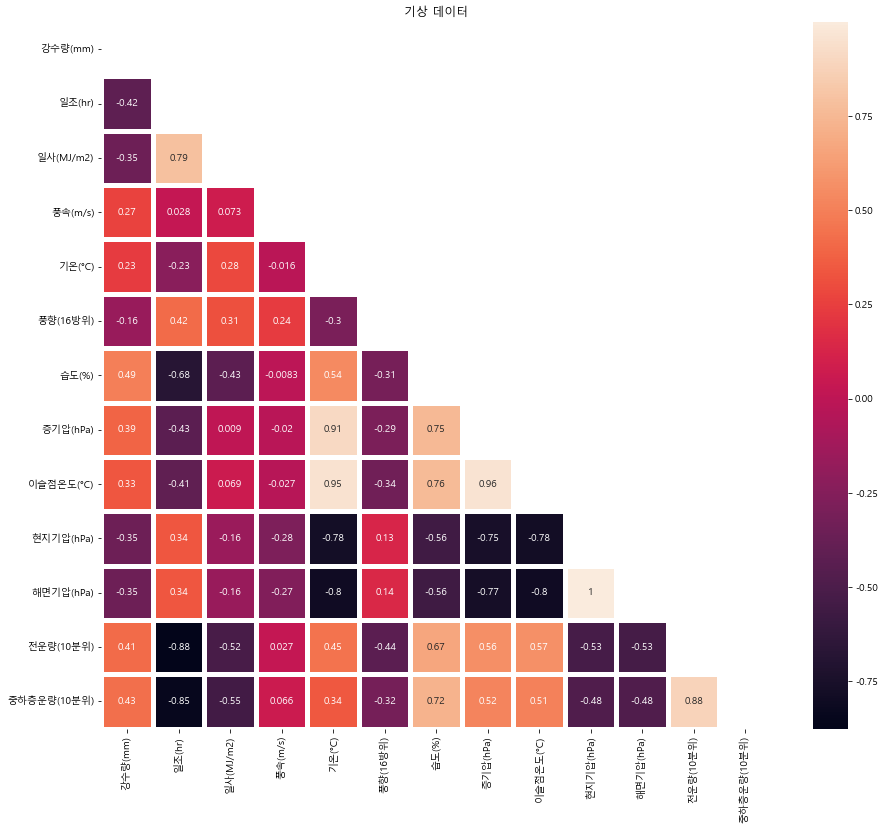

In [93]:
plt.figure(figsize=(15,13))
mask = np.zeros_like(daily_weather.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(daily_weather.corr(), annot=True, linewidth=5, mask=mask)
plt.title('기상 데이터')
plt.show()

<AxesSubplot:>

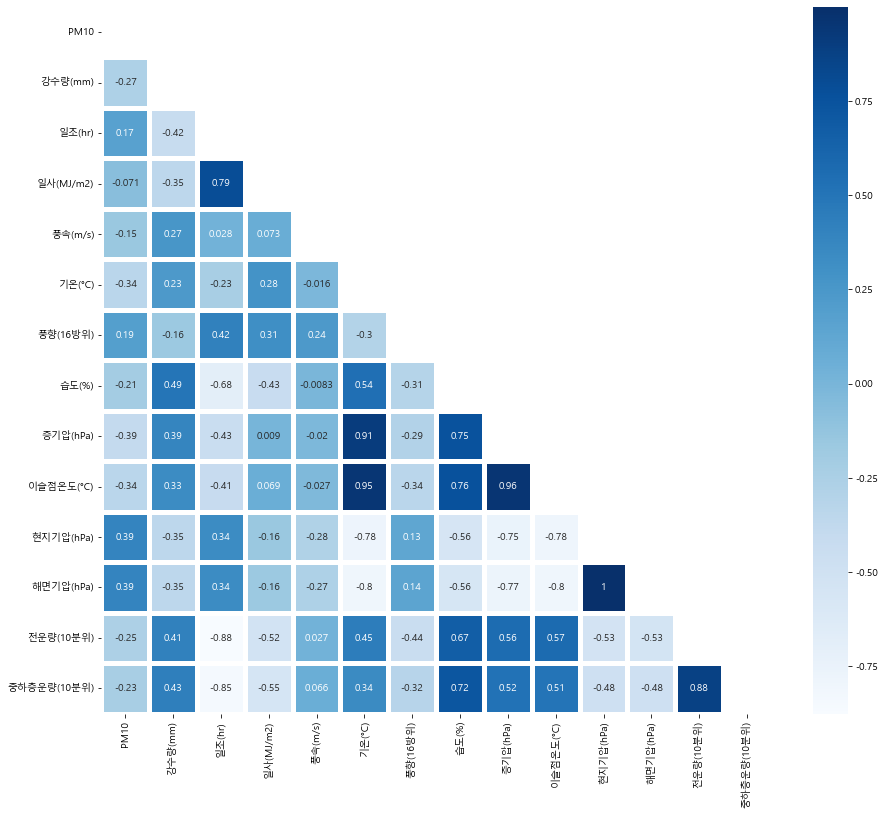

In [94]:
total = pd.merge(daily_air[['PM10']], daily_weather,left_index= True, right_index= True, how='inner')
plt.figure(figsize=(15,13))
mask = np.zeros_like(total.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(total.corr(), annot=True, linewidth=5, mask=mask, cmap='Blues')

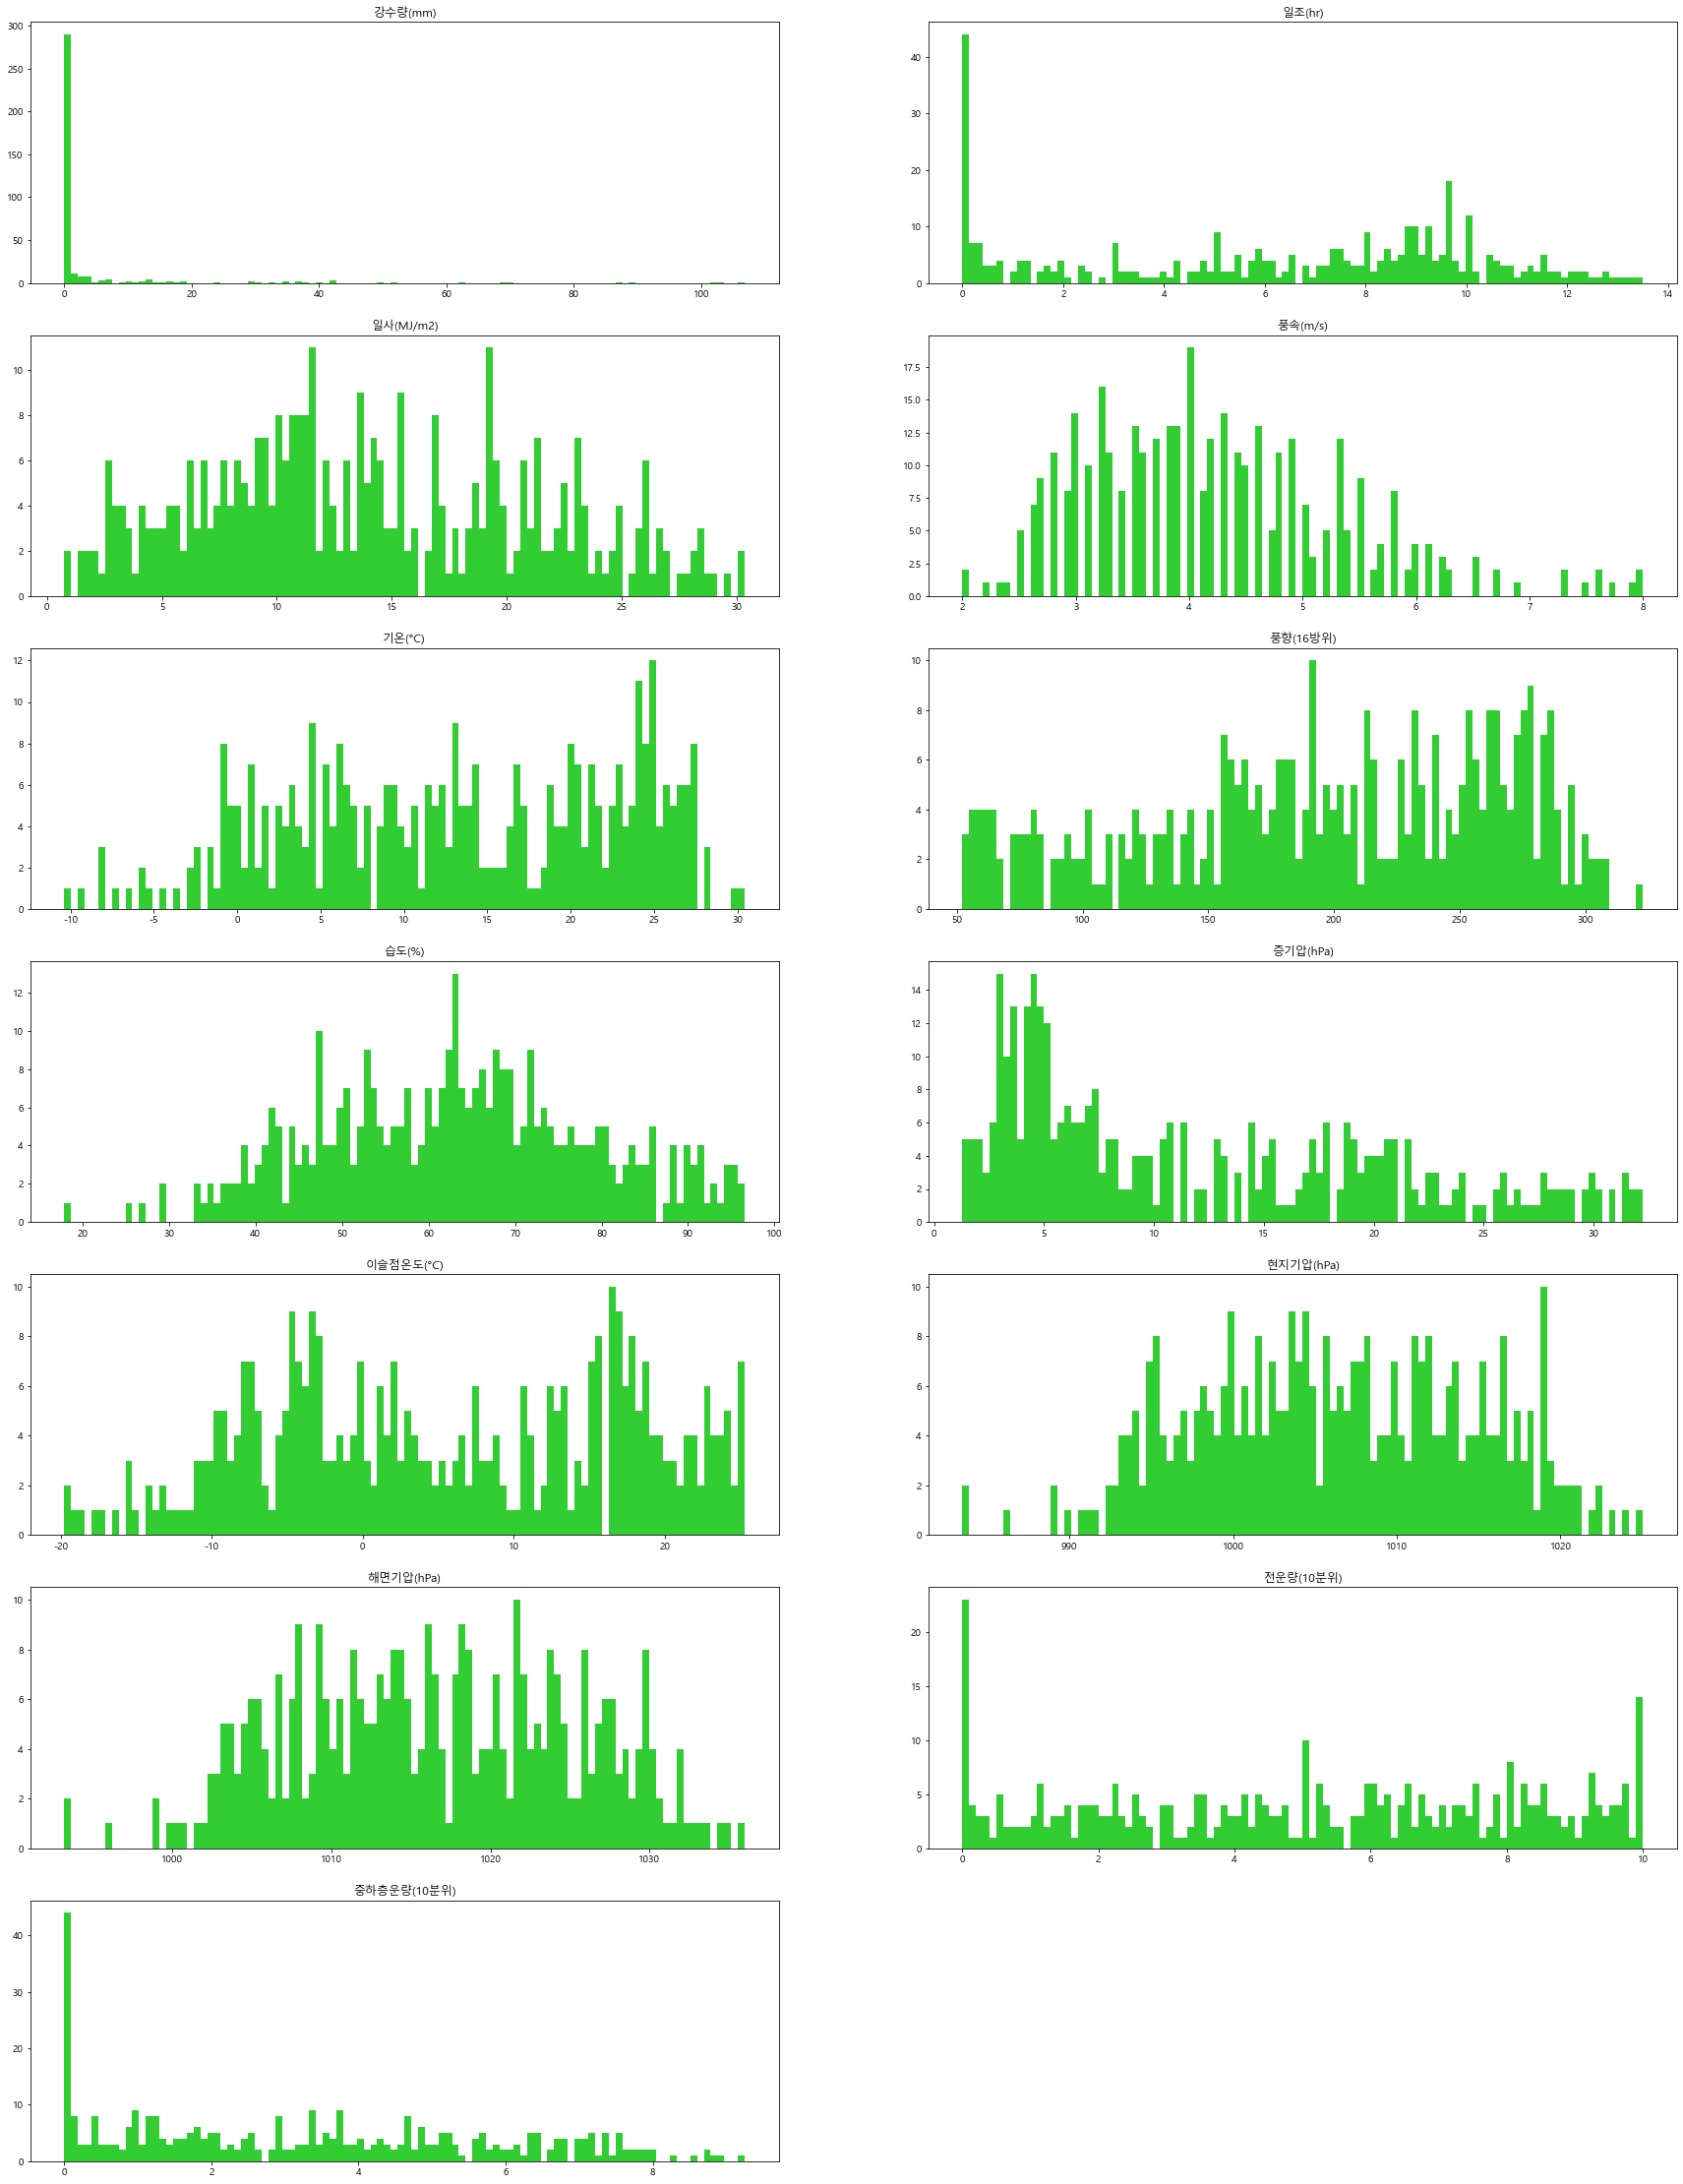

In [95]:
fig = plt.figure(figsize=(30, 40))
i = 1
for c in daily_weather.columns :
    ax = fig.add_subplot(7, 2, i)
    i += 1
    ax.hist(daily_weather[c], bins=100, color='limegreen')
    ax.set_title(c)
plt.show()

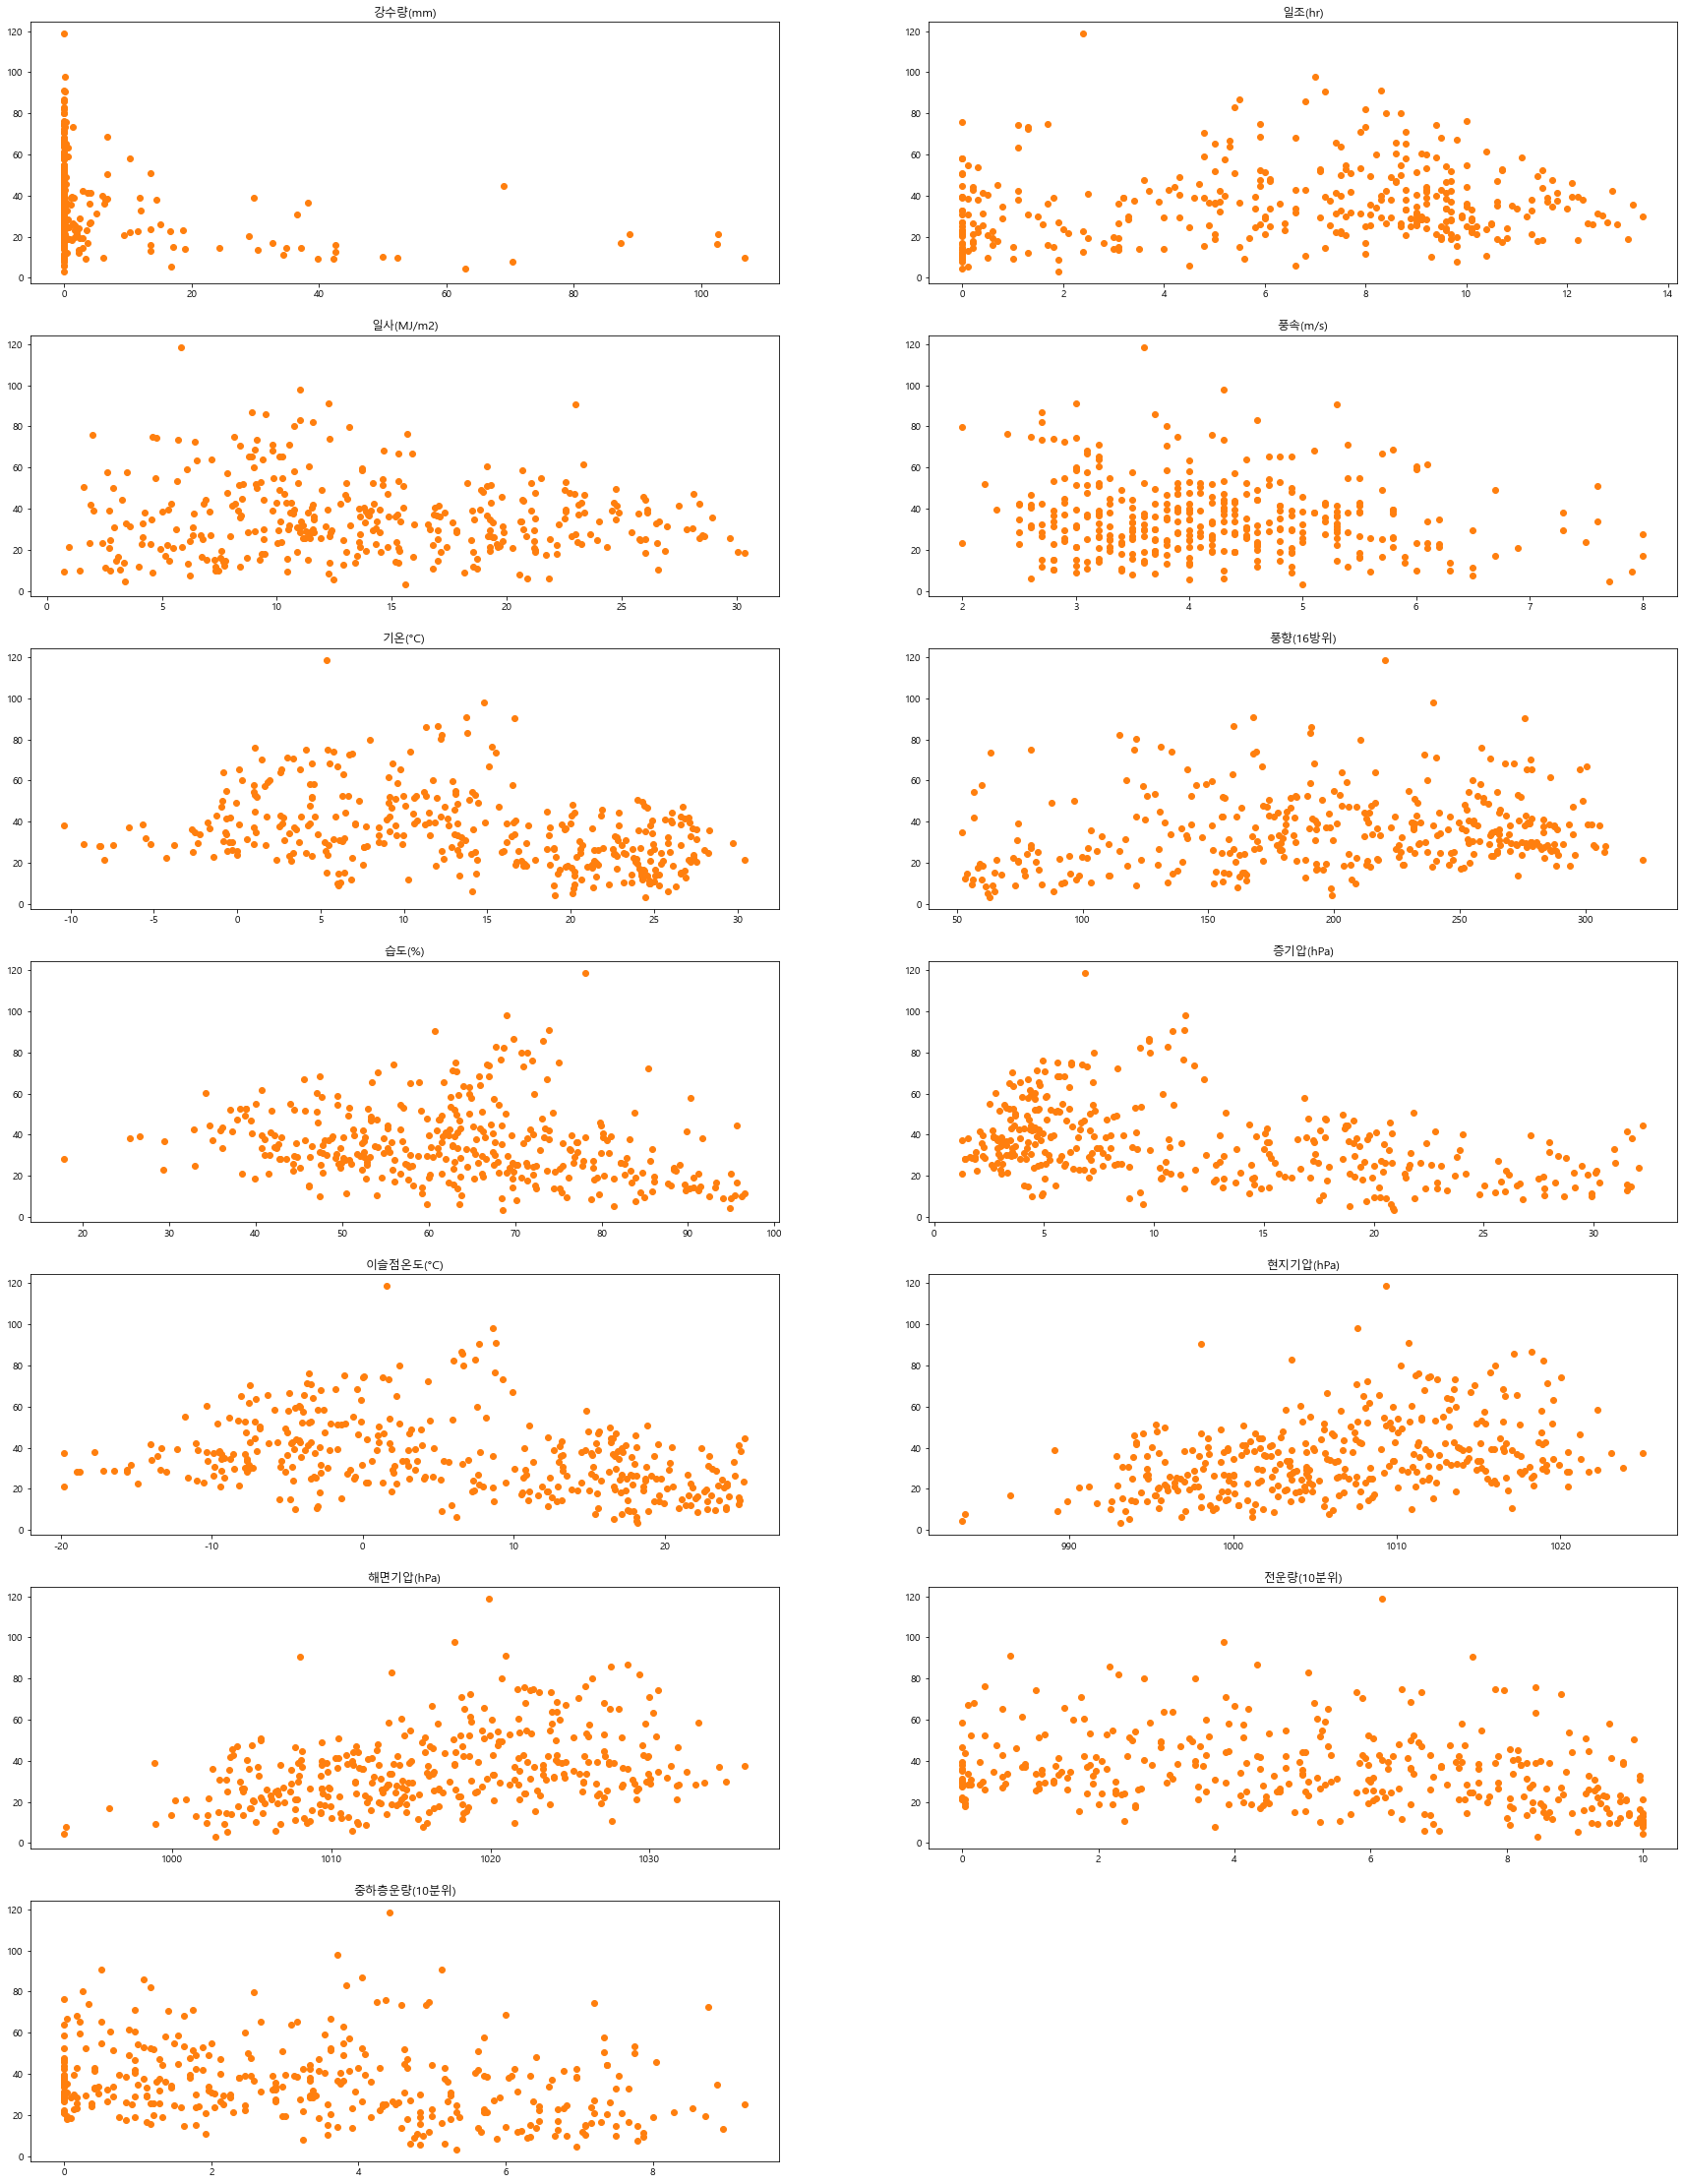

In [98]:
fig = plt.figure(figsize=(30, 40))
i = 1
for c in daily_weather.columns :
    ax = fig.add_subplot(7, 2, i)
    i += 1
    ax.scatter(daily_weather[c], daily_air['PM10'],color='#ff7f0e')
    ax.set_title(c)
plt.show()

PM10 -> 단계별 카테고리화

In [99]:
def PM10_cat(x):
    if x <=30 :
        return 1
    elif x <=80 :
        return 2
    elif x <= 150 :
        return 3
    else :
        return 4

finedust = pd.DataFrame({'PM10' : daily_air['PM10'].map(PM10_cat)},
                        index=daily_air.index)
finedust.head()

,PM10
일,
2020-01-01,2
2020-01-02,2
2020-01-03,2
2020-01-04,2
2020-01-05,2


기상 데이터에 '월' 컬럼 추가

In [100]:
daily_weather['월'] = daily_weather.index.map(lambda x : x.month)
daily_weather.head()

,강수량(mm),일조(hr),일사(MJ/m2),풍속(m/s),기온(°C),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),전운량(10분위),중하층운량(10분위),월
일,,,,,,,,,,,,,,
2020-01-01,0.1,0.8,4.53,2.5,-2.543478,52.173913,62.739130,3.278261,-8.778261,1021.247826,1032.326087,8.869565,8.869565,1
2020-01-02,0.0,0.0,3.47,3.1,0.987500,145.000000,64.875000,4.254167,-4.904167,1018.837500,1029.729167,7.333333,7.333333,1
2020-01-03,0.0,8.8,10.10,3.2,0.120833,297.916667,57.833333,3.404167,-8.054167,1016.633333,1027.520833,0.583333,0.208333,1
2020-01-04,0.0,7.9,9.29,4.0,1.054167,202.500000,50.875000,3.287500,-8.262500,1015.166667,1026.016667,1.875000,1.875000,1
2020-01-05,0.0,7.1,9.10,2.2,1.175000,155.833333,45.666667,2.954167,-9.616667,1019.504167,1030.391667,3.625000,1.208333,1


### 피처추출(?)
**상관계수가 높은 컬럼들 삭제**

다중 공선성때문인데,
상관계수가 높은 것은 데이터 분석에 악영향을 준다.
각 변수의 설명력이 약해져 표준오차의 증가로 드러난다.

따라서 다중공선성문제 때문에 상관계수가 높은, 0.9이상인 것은 삭제해주거나
PCA 등을 통해 차원 축소를 해줄 수 있다.

해면기압, 현지기압 상관계수가 1, 기온 & (증기압, 이슬점온도)도 상관계수가 0.9이상이므로
해당 컬럼삭제


In [104]:
daily_weather.drop(['해면기압(hPa)', '증기압(hPa)', '이슬점온도(°C)'], axis=1, inplace=True)

### 정규화

In [111]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(daily_weather)
col = daily_weather.columns
nomalized_daily_weather = scaler.transform(daily_weather)
nomalized_daily_weather = pd.DataFrame(data=nomalized_daily_weather,
                                       columns=col,
                                       index=daily_weather.index)

In [112]:
total = pd.merge(finedust, nomalized_daily_weather,
                 left_index=True,
                 right_index=True,
                 how='inner')
total

,PM10,강수량(mm),일조(hr),일사(MJ/m2),풍속(m/s),기온(°C),풍향(16방위),습도(%),현지기압(hPa),전운량(10분위),중하층운량(10분위),월
일,,,,,,,,,,,,
2020-01-01,2,-0.296083,-1.357712,-1.337963,-1.491584,-1.638672,-2.060027,-0.033511,1.806352,1.220888,2.210616,-1.597591
2020-01-02,2,-0.302795,-1.559415,-1.488059,-0.969006,-1.272790,-0.733393,0.103308,1.515981,0.726758,1.602230,-1.597591
2020-01-03,2,-0.302795,0.659326,-0.549252,-0.881910,-1.362595,1.452034,-0.347763,1.250445,-1.444384,-1.219448,-1.597591
2020-01-04,2,-0.302795,0.432409,-0.663948,-0.185139,-1.265882,0.088375,-0.793496,1.073756,-1.028918,-0.559406,-1.597591
2020-01-05,2,-0.302795,0.230706,-0.690852,-1.752873,-1.253361,-0.578567,-1.127128,1.596294,-0.466030,-0.823423,-1.597591
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2,-0.302795,-0.071850,-0.829620,-1.404488,-0.815996,-1.668302,-0.008793,0.585351,0.887583,0.381153,1.589675
2020-12-28,2,-0.215538,0.457622,-0.688020,-1.317392,-0.657974,-0.405876,0.495659,0.749491,0.230880,0.513161,1.589675
2020-12-29,2,-0.289371,-1.559415,-1.699042,-0.010947,-1.268041,0.892279,0.557048,0.610951,1.075213,0.430656,1.589675


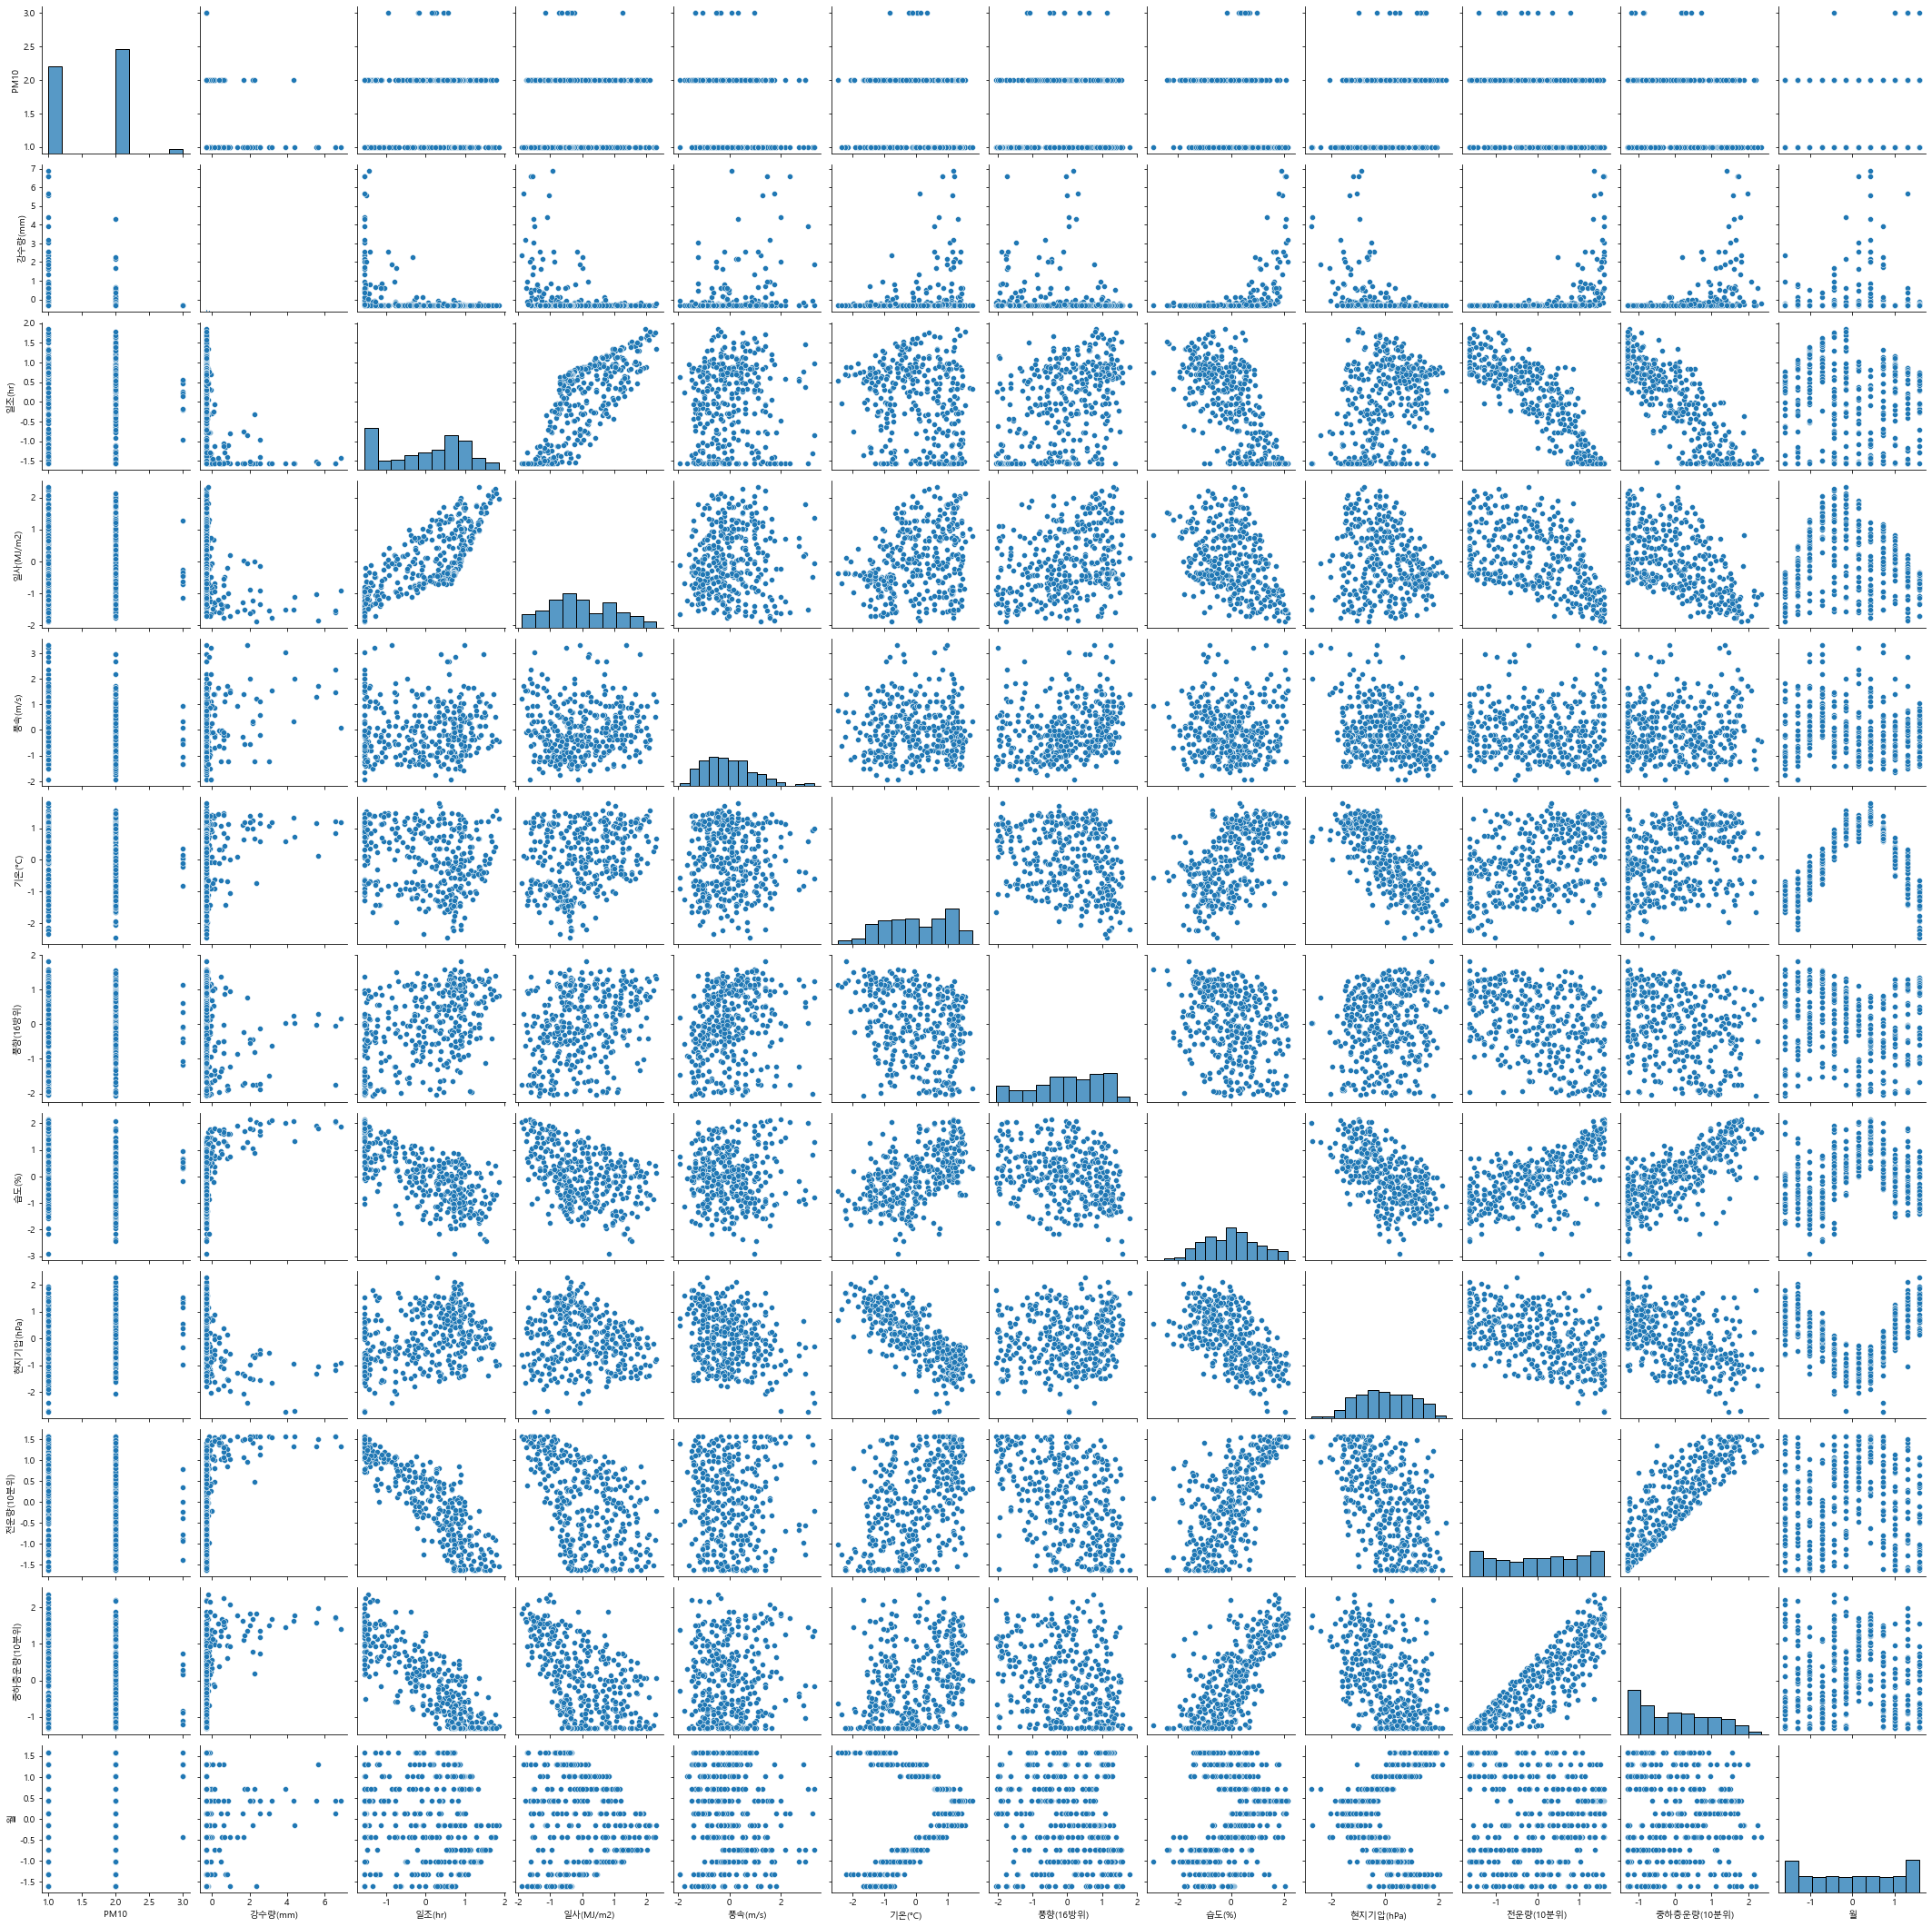

In [113]:
sns.pairplot(total)

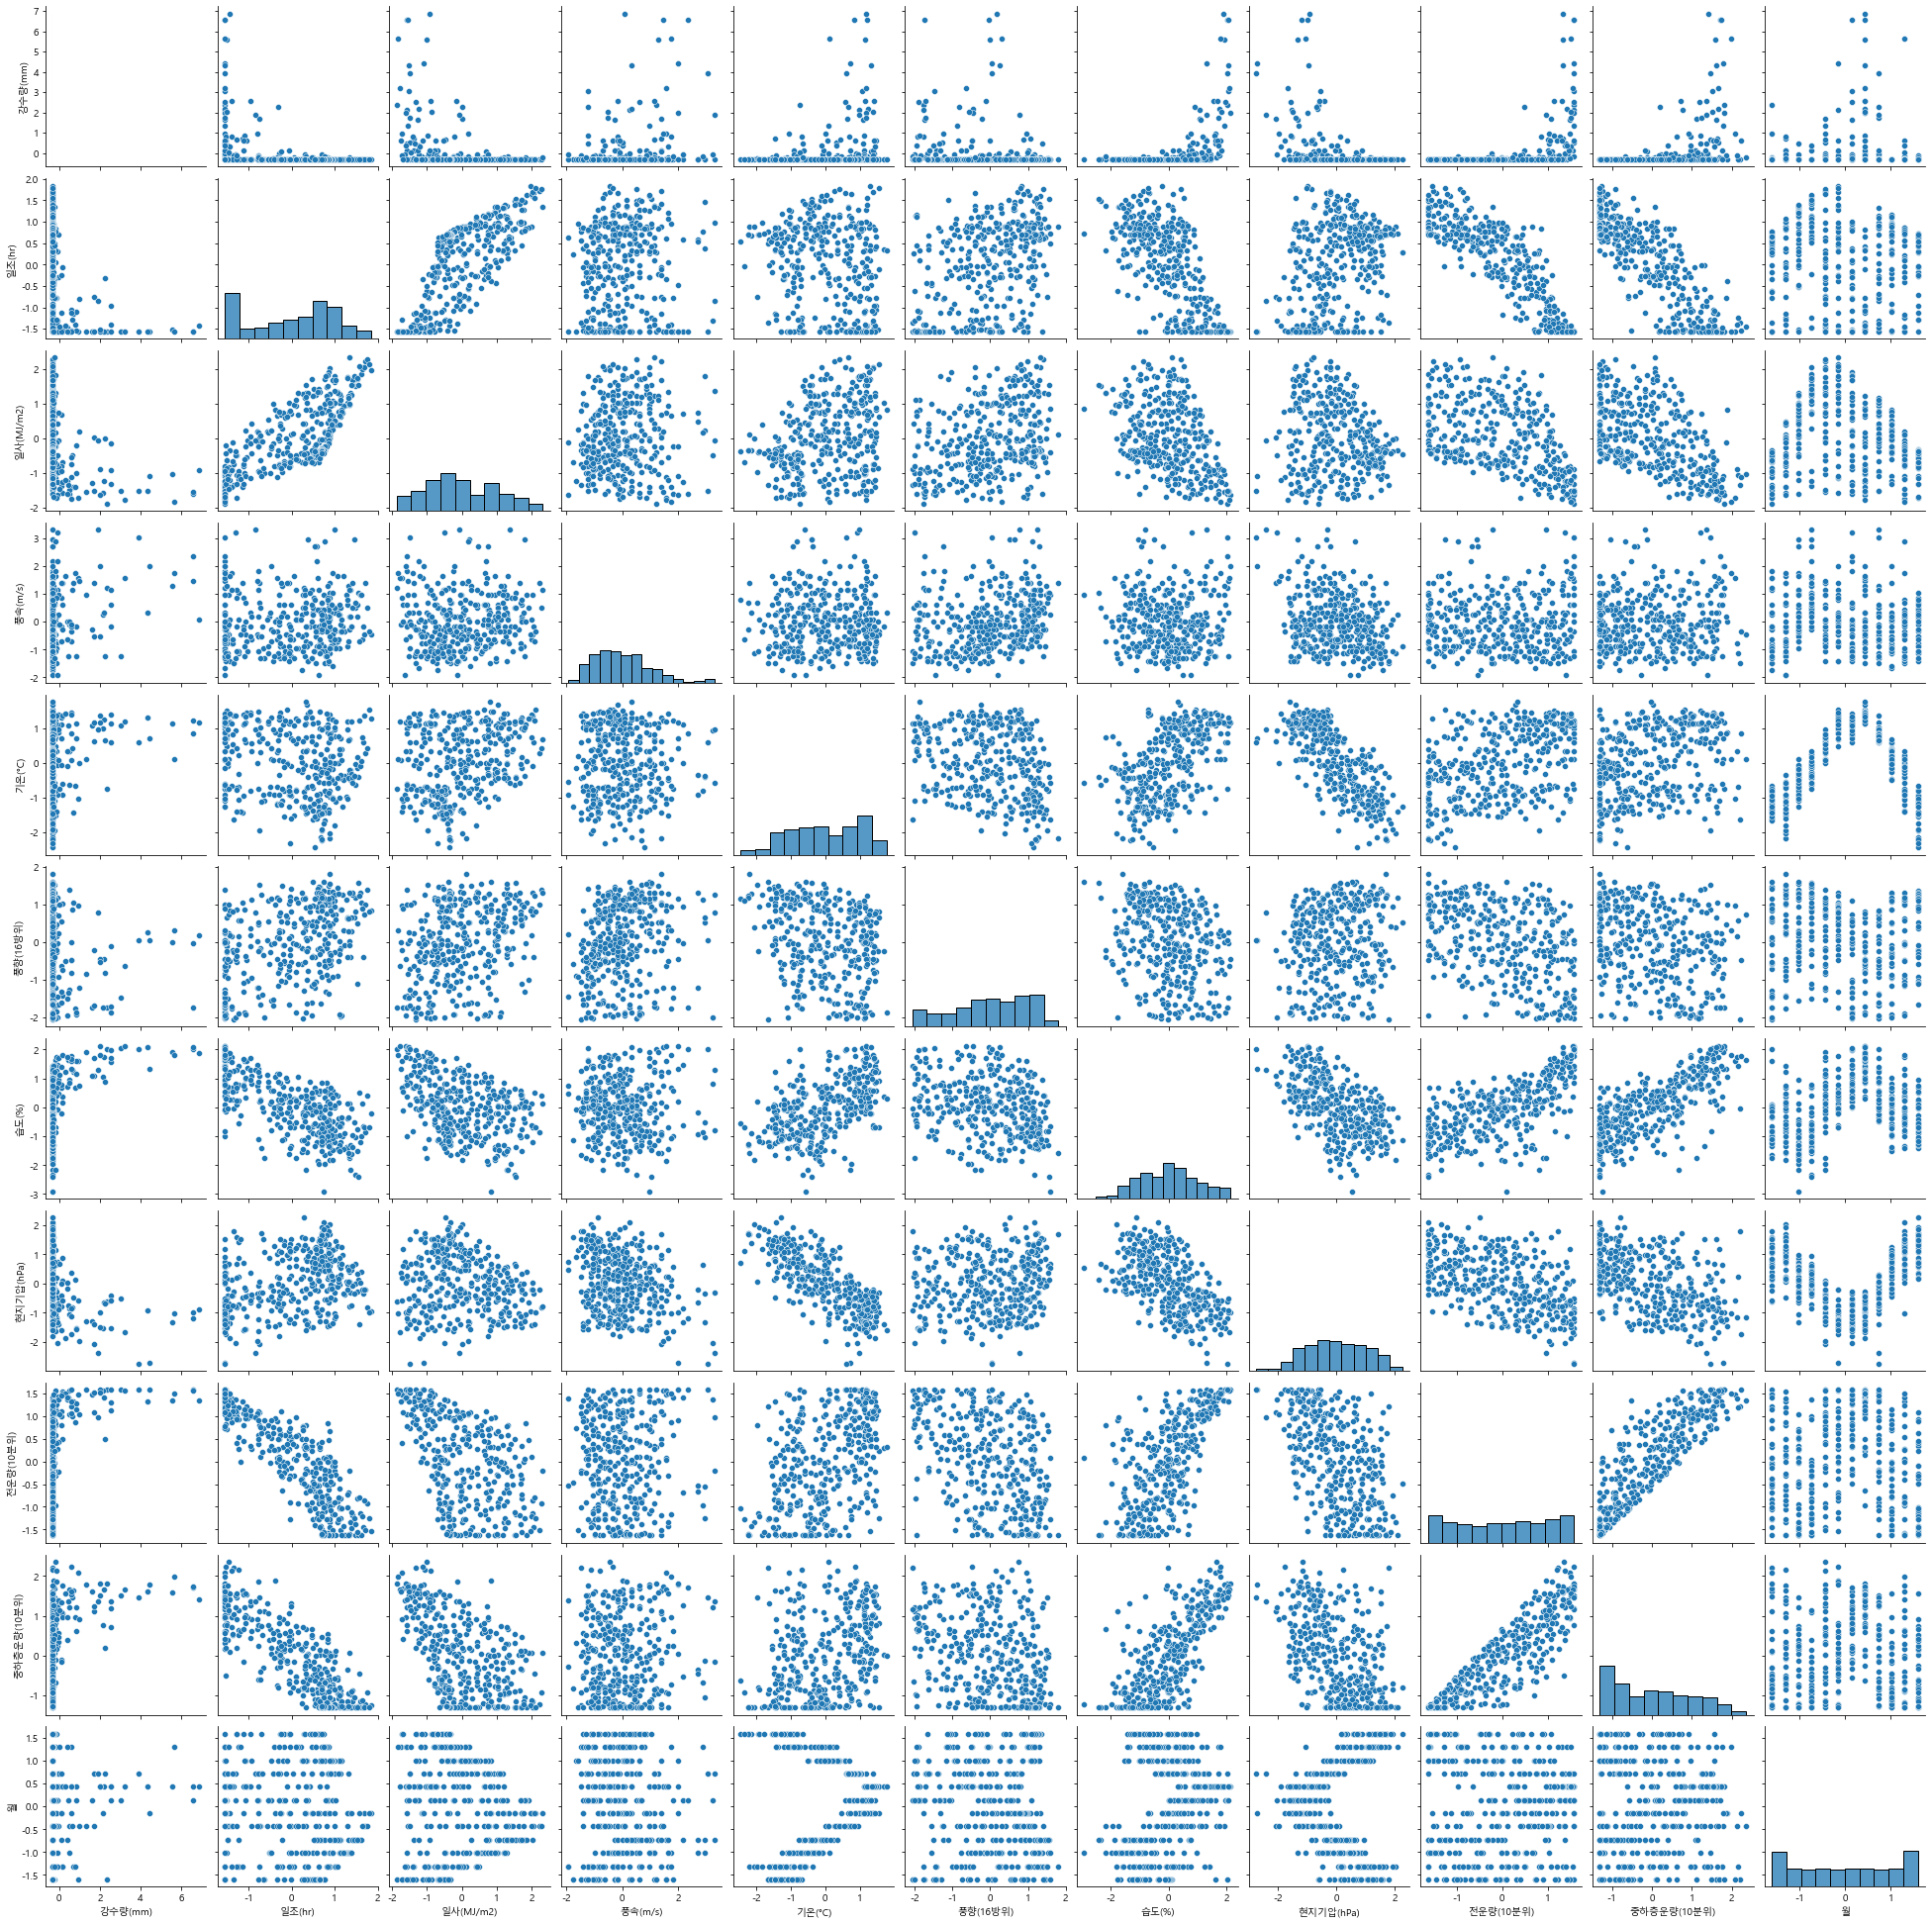

In [114]:
sns.pairplot(nomalized_daily_weather)
plt.show()

# 3. Machine Learning

<사용할 데이터>
- finedust : PM10을 단계별로 나타낸 데이터
- nomalized_daily_weather : 일별 기상 데이터

In [117]:
finedust

,PM10
일,
2020-01-01,2
2020-01-02,2
2020-01-03,2
2020-01-04,2
2020-01-05,2
...,...
2020-12-27,2
2020-12-28,2
2020-12-29,2


In [118]:
nomalized_daily_weather

,강수량(mm),일조(hr),일사(MJ/m2),풍속(m/s),기온(°C),풍향(16방위),습도(%),현지기압(hPa),전운량(10분위),중하층운량(10분위),월
일,,,,,,,,,,,
2020-01-01,-0.296083,-1.357712,-1.337963,-1.491584,-1.638672,-2.060027,-0.033511,1.806352,1.220888,2.210616,-1.597591
2020-01-02,-0.302795,-1.559415,-1.488059,-0.969006,-1.272790,-0.733393,0.103308,1.515981,0.726758,1.602230,-1.597591
2020-01-03,-0.302795,0.659326,-0.549252,-0.881910,-1.362595,1.452034,-0.347763,1.250445,-1.444384,-1.219448,-1.597591
2020-01-04,-0.302795,0.432409,-0.663948,-0.185139,-1.265882,0.088375,-0.793496,1.073756,-1.028918,-0.559406,-1.597591
2020-01-05,-0.302795,0.230706,-0.690852,-1.752873,-1.253361,-0.578567,-1.127128,1.596294,-0.466030,-0.823423,-1.597591
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,-0.302795,-0.071850,-0.829620,-1.404488,-0.815996,-1.668302,-0.008793,0.585351,0.887583,0.381153,1.589675
2020-12-28,-0.215538,0.457622,-0.688020,-1.317392,-0.657974,-0.405876,0.495659,0.749491,0.230880,0.513161,1.589675
2020-12-29,-0.289371,-1.559415,-1.699042,-0.010947,-1.268041,0.892279,0.557048,0.610951,1.075213,0.430656,1.589675


target data는 1,2,3의 값을 가졌고
x data는 정규화로 continuous한 값을 가진채로 학습을 했는데
맞게 한 것인지 모르겠다.

=> RandomForest 학습 시 오류
Classification metrics can't handle a mix of multiclass and continuous targets

1. target data를 원 핫 인코딩을 해야하는지
2. x data를 정규화가 아니라 min max scaling을 했어야 하는 것인지

### data split

In [127]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(nomalized_daily_weather, finedust, test_size=0.2, random_state=11)

# Logistic Regression

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_clf = LogisticRegression(max_iter=200)

lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_test)
print('Logistic Regression 정확도 : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

Logistic Regression 정확도 : 0.5811


# GBM

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
import time
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(x_train, y_train)
gb_pred = gb_clf.predict(x_test)
gb_acc = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_acc))
print('GBM 수행시간 : {0:.1f}초'.format(time.time()-start_time))

GBM 정확도 : 0.7838
GBM 수행시간 : 0.4초


# 4. Predict

- columns
'일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)',
'증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)',
'일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)'

In [147]:
def weather_preprocessing(df) :
    df.drop(['지점', '지점명'], axis=1, inplace=True)
    # null 값처리
    df['기온(°C)'].fillna(method='bfill', inplace=True)
    df['증기압(hPa)'].fillna(method='bfill', inplace=True)
    df['이슬점온도(°C)'].fillna(method='bfill', inplace=True)
    df['현지기압(hPa)'].fillna(method='bfill', inplace=True)
    df['해면기압(hPa)'].fillna(method='bfill', inplace=True)
    df['전운량(10분위)'].fillna(method='bfill', inplace=True)
    df['중하층운량(10분위)'].fillna(method='bfill', inplace=True)

    df['강수량(mm)'].fillna(0, inplace=True)
    df['일조(hr)'].fillna(0, inplace=True)
    df['일사(MJ/m2)'].fillna(0, inplace=True)
    df.drop('최저운고(100m )', axis=1, inplace=True)

    # 데이터 타입 변경, 인덱스 변경
    df.rename(columns = {"일시": "날짜"}, inplace = True)
    df['날짜'] = df['날짜'].map(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M'))
    df.set_index(df['날짜'], inplace=True)
    df.drop('날짜', axis=1, inplace=True)

    def only_date(x) :
        return date(x.year, x.month, x.day)
    df['일'] = df.index.map(only_date)

    grouped = df.groupby('일')
    hap = grouped[['강수량(mm)', '일조(hr)', '일사(MJ/m2)']].sum()
    maxi = grouped[['풍속(m/s)']].max()
    ave = grouped[['기온(°C)', '풍향(16방위)','습도(%)', '증기압(hPa)',
       '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '전운량(10분위)', '중하층운량(10분위)']].mean()

    df = pd.concat([hap, maxi, ave], axis= 1)

    df.drop(['해면기압(hPa)', '증기압(hPa)', '이슬점온도(°C)'], axis=1, inplace=True)
    df['월'] = df.index.map(lambda x : x.month)

    col = df.columns
    index = df.index
    # 위에서 사용한 스케일러
    df = scaler.transform(df)
    df = pd.DataFrame(data=df, columns=col, index=index)

    return df

In [183]:
def finedust_preprocessing(df) :
    df.drop([df.index[0]], inplace=True)

    df['날짜'] = df['날짜'].map(lambda x : '2021-'+x[:5]+" "+x[6:]+":00" )

    def converting_date(x):
        h = x[11:13]
        d = x[:10]
        if h == '24' :
            d = datetime.strptime(d, '%Y-%m-%d')  # 문자열 => datetime
            d = d + timedelta(days=1)
            d = datetime.strftime(d, '%Y-%m-%d %H:%M') # datetime => 문자열
            return d
        else :
            return x

    df['날짜'] = df['날짜'].map(converting_date)
    df = df.fillna(method='bfill')
    df['날짜'] = df['날짜'].map(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M'))

    df = pd.DataFrame({'PM10' : df['PM10'].values}, index=df['날짜'])

    df['PM10'] =df['PM10'].astype('int32')

    def only_date(x) :
        return date(x.year, x.month, x.day)
    df['일'] = df.index.map(only_date)
    df = df.groupby('일').mean()

    def PM10_cat(x):
        if x <=30 :
            return 1
        elif x <=80 :
            return 2
        elif x <= 150 :
            return 3
        else :
            return 4

    df['PM10'] = df['PM10'].map(PM10_cat)
    df.drop([df.index[-1]], inplace=True)
    return df

In [148]:
x_predict = pd.read_csv('C:/jupyter_home/data/finedust/21년_1월_기상.csv')
x_predict = weather_preprocessing(x_predict)
x_predict

,강수량(mm),일조(hr),일사(MJ/m2),풍속(m/s),기온(°C),풍향(16방위),습도(%),현지기압(hPa),전운량(10분위),중하층운량(10분위),월
일,,,,,,,,,,,
2021-01-01,-0.302795,0.079428,-0.628548,-0.359332,-1.836453,-0.258041,0.102959,1.045297,-0.681046,-0.199971,-1.597591
2021-01-02,-0.302795,0.709752,-0.373669,0.860017,-1.865155,1.321027,-1.546171,1.407558,-1.632013,-1.301953,-1.597591
2021-01-03,-0.302795,-0.172702,-0.733332,-0.359332,-1.958414,1.100698,-1.207200,2.001876,-0.921701,-0.988433,-1.597591
2021-01-04,-0.302795,-0.399619,-0.925908,-1.404488,-1.765852,-0.804851,-0.921611,1.744371,-0.399019,0.183140,-1.597591
2021-01-05,-0.302795,0.608900,-0.498276,0.598728,-1.876381,1.130472,-0.577302,1.560153,-0.667061,-0.262388,-1.597591
2021-01-06,-0.155129,0.734965,-0.311365,-0.620621,-2.137591,0.398027,-0.601324,0.869961,-0.854691,-0.542905,-1.597591
2021-01-07,-0.296083,-0.046637,-1.019363,1.905173,-2.806808,1.338892,-0.772144,1.023560,-1.136135,-0.757419,-1.597591
2021-01-08,-0.302795,0.760178,-0.226405,1.382595,-2.923813,1.053059,-1.193855,0.955796,-1.618611,-1.301953,-1.597591
2021-01-09,-0.302795,0.709752,-0.338269,1.382595,-2.658285,0.928008,-1.169833,0.901082,-1.417580,-1.186446,-1.597591


In [184]:
y_predict = pd.read_excel('C:/jupyter_home/data/finedust/21년_1월_대기.xls')
y_predict = finedust_preprocessing(y_predict)
y_predict

,PM10
일,
2021-01-01,1
2021-01-02,2
2021-01-03,2
2021-01-04,2
2021-01-05,1
2021-01-06,1
2021-01-07,2
2021-01-08,1
2021-01-09,1


In [185]:
gb_pred = gb_clf.predict(x_predict)
gb_acc = accuracy_score(y_predict, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_acc))

GBM 정확도 : 0.5161


처음부터 실제 데이터를 다루려니 너무 어려웠고,
어떤 모델을 써야할지도 감이 잘 안 잡혀서
난이도가 쉬운 예제들부터 차례로 공부해보아야겠다.